In [13]:
import os
import base64
import requests
from io import BytesIO
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import seaborn as sns

In [14]:
def get_quotes(api_key, ticker, n_days=252):
    """
    Get quotes for a given ticker
    Legacy:
        quotes = yf.Ticker(ticker).history(period=period)
        quotes.index = pd.to_datetime(quotes.index.strftime('%Y-%m-%d'))
        return quotes
    """
    url = "https://api.twelvedata.com/time_series?"
    url = url + f"symbol={ticker}&interval=1day&outputsize={n_days}&apikey={api_key}"

    try:
        response = requests.get(url, timeout=5)
        response.raise_for_status()
    except requests.exceptions.RequestException as e:
        print(f"Failed to fetch data from twelvedata: {e}")
        return None

    try:
        data = pd.DataFrame(response.json()['values'])
    except ValueError:
        print(f"Failed to parse data from twelvedata: {response.json()}")
        return None

    data['datetime'] = pd.to_datetime(data['datetime'])
    data.set_index('datetime', inplace=True)
    data = data.apply(pd.to_numeric)
    data.sort_index(ascending=True, inplace=True)
    return data

In [9]:
api_key = os.environ.get("QUOTES_API_KEY")
spx = get_quotes(api_key, "SPX")
spx.to_pickle("spx.pickle")

In [3]:
estimators = [
    "close_to_close",
    "parkinson",
    "garman_klass",
    "rogers_satchell",
    "yang_zhang",
]

windows = [30, 60, 90, 120]

spx = get_market_quotes("^SPX")
vix = get_market_quotes("^VIX")

ens = VolatilityEstimator(estimators=estimators)
vols = multi_window_estimates(
    estimator=ens,
    price_data=spx,
    windows=windows,
    components=True)

## Plot 1

<Axes: xlabel='Date'>

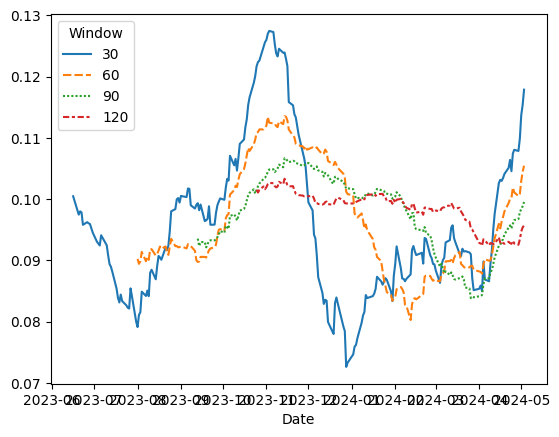

In [4]:
sns.lineplot(vols.xs("mean", level="Estimator", axis=1))

<Axes: xlabel='Window'>

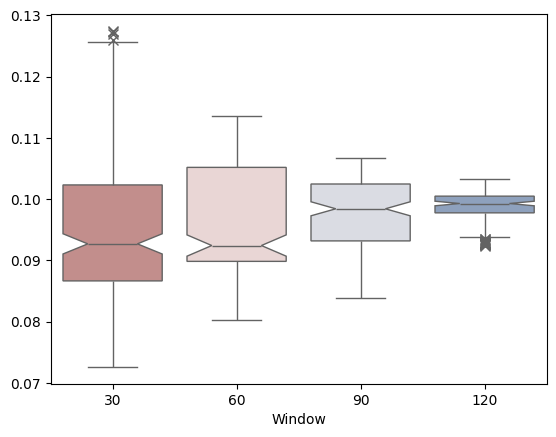

In [5]:
data = vols.xs("mean", level="Estimator", axis=1)
data.columns = data.columns.get_level_values(0)
sns.boxplot(
    data,
    notch=True,
    palette="vlag_r",
    fliersize=7,
    flierprops={'marker':'x'})

<Axes: xlabel='Window', ylabel='2024-05-03 00:00:00'>

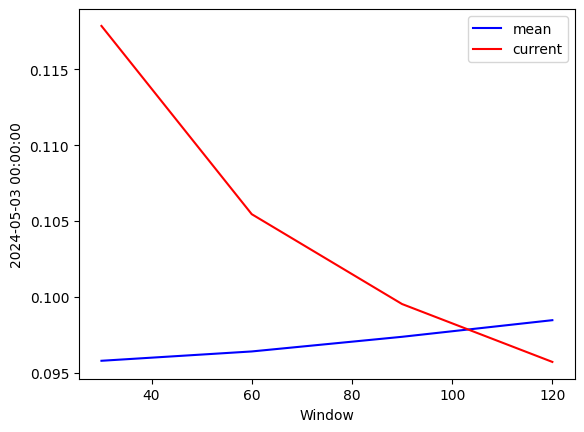

In [6]:
data.mean(axis=0)
sns.lineplot(data.mean(axis=0), color="blue", label="mean")
sns.lineplot(data.iloc[-1], color="red", label="current")

In [7]:
data.mean(axis=0)

Window
30     0.095794
60     0.096409
90     0.097374
120    0.098469
dtype: float64

In [8]:
data.iloc[-1].values

array([0.1178566 , 0.10545228, 0.09953275, 0.09571859])

In [9]:
data = vols.xs("mean", level="Estimator", axis=1)
data.columns = data.columns.get_level_values(0)
data.loc[:,30]

Date
2023-06-16    0.100461
2023-06-20    0.097459
2023-06-21    0.097997
2023-06-22    0.097821
2023-06-23    0.095796
                ...   
2024-04-29    0.107849
2024-04-30    0.109886
2024-05-01    0.113712
2024-05-02    0.115359
2024-05-03    0.117857
Name: 30, Length: 222, dtype: float64

Text(0, 0.5, '')

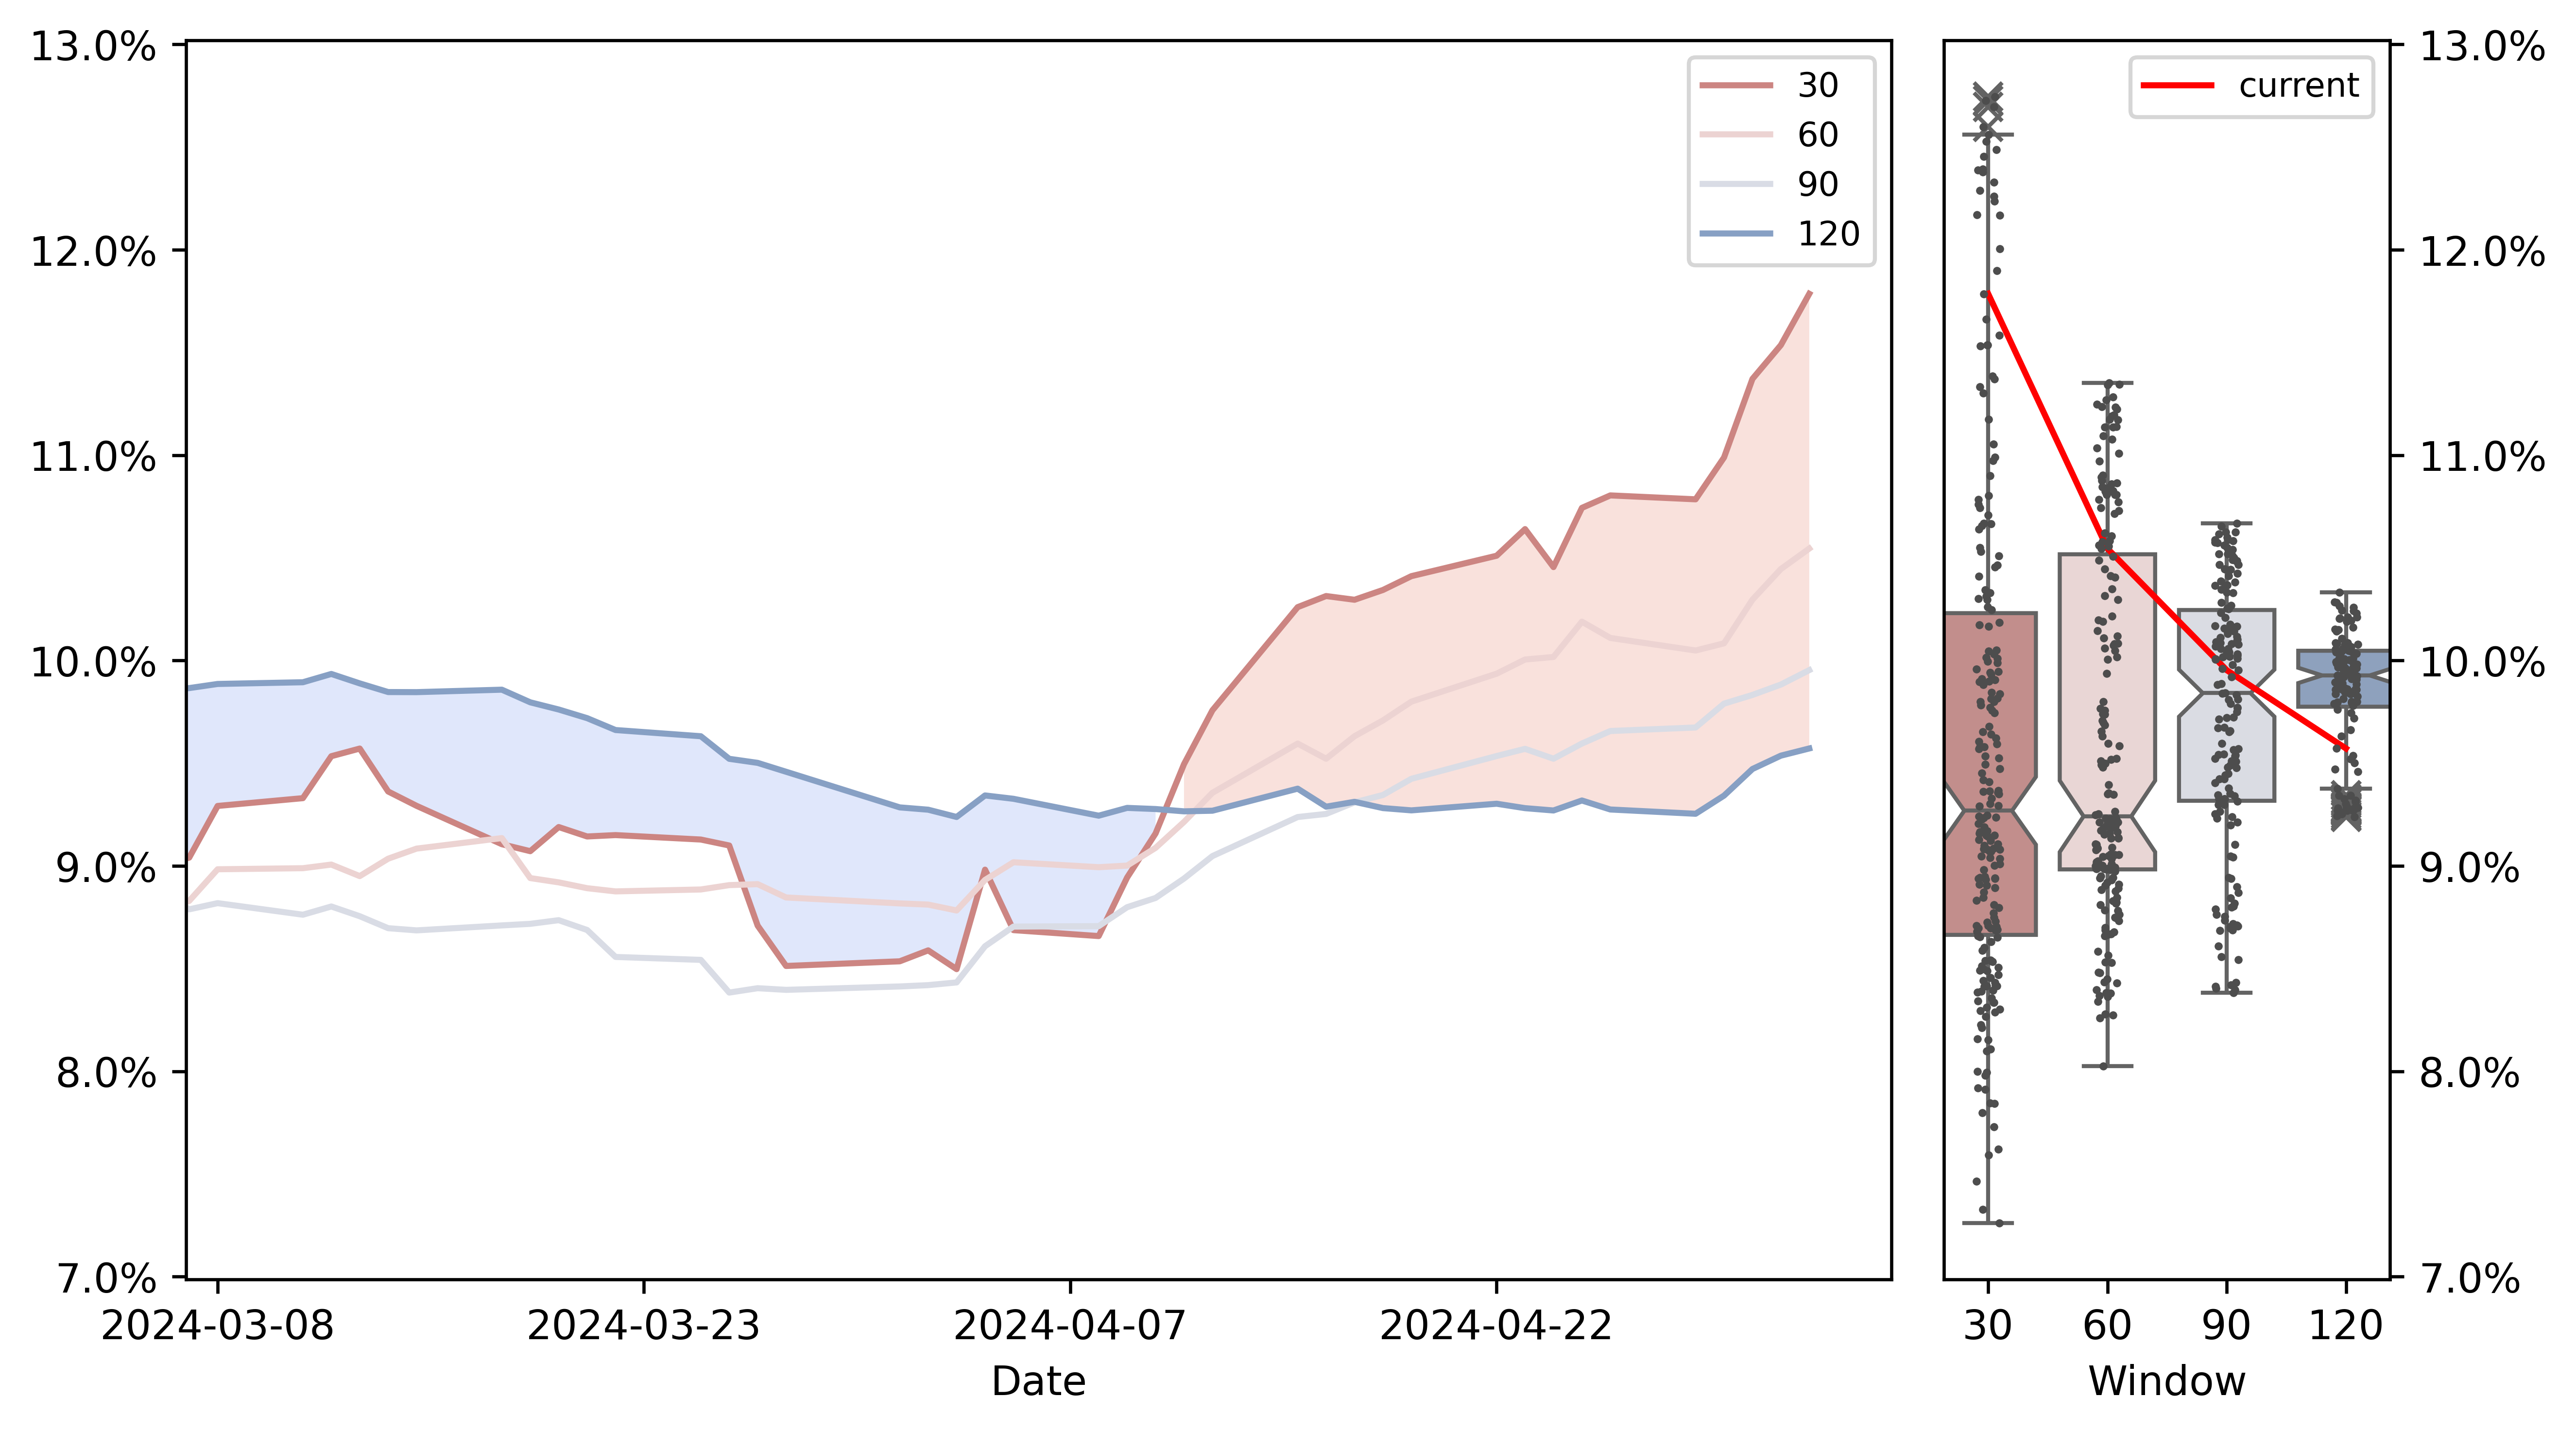

In [10]:
data = vols.xs("mean", level="Estimator", axis=1)
data.columns = data.columns.get_level_values(0)

min_window = data.columns.min()
max_window = data.columns.max()

def to_percentage(value, _):
    return f'{100 * value:.1f}%'

# Figure setup
plt.figure(figsize=(9,5), dpi=600)
left, width = 0.09, 0.65
bottom, height = 0.1, 0.85
left_h = left+width+0.02
rect_left = [left, bottom, width, height]
rect_right = [left_h, bottom, 0.17, height]
left = plt.axes(rect_left)
right = plt.axes(rect_right)

# First subplot using Seaborn
sns.lineplot(
    data,
    palette="vlag_r",
    errorbar="sd",
    dashes=False,
    ax=left)

left.fill_between(
    data.index,
    data.loc[:,min_window],
    data.loc[:,max_window],
    where=(data.loc[:,min_window] > data.loc[:,max_window]),
    color=sns.color_palette("coolwarm")[-1],
    linewidth=0,
    alpha=.2)

left.fill_between(
    data.index,
    data.loc[:,min_window],
    data.loc[:,max_window],
    where=(data.loc[:,min_window] <= data.loc[:,max_window]),
    color=sns.color_palette("coolwarm")[0],
    linewidth=0,
    alpha=.2)

# Setting date-specific x-ticks every 20 days
end_date = pd.Timestamp('today')
start_date = end_date - pd.Timedelta(days=60)
left.set_xlim(start_date, end_date)

# Set x-axis major ticks to every 15 days
left.xaxis.set_major_locator(mdates.DayLocator(interval=15))
left.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
left.legend(fontsize='small')

# Rotate date labels to prevent overlap
plt.gcf().autofmt_xdate()

# Second subplot
means = data.mean(axis=0).values
currs = data.iloc[-1].values

sns.boxplot(
    data,
    notch=True,
    palette="vlag_r",
    fliersize=7,
    flierprops={'marker':'x'},
    ax=right)
sns.stripplot(data, size=2, color=".3", ax=right)
# sns.lineplot(means, color="red", linestyle='dashed', label="mean", ax=right)
sns.lineplot(currs, color="red", label="current", ax=right)
right.legend(fontsize='small')

# change y-ticks
left.yaxis.set_major_formatter(FuncFormatter(to_percentage))
right.yaxis.set_major_formatter(FuncFormatter(to_percentage))
right.yaxis.tick_right()
right.set_ylabel("")

In [11]:
means>currs

array([False, False, False,  True])

## Plot 2 - violins

In [12]:
df_long = vols.stack(level=[0, 1], future_stack=True).reset_index()
df_long.columns = ['Index', 'Estimator', 'Window', 'Value']
df_long

,Index,Estimator,Window,Value
0,2023-06-16,close_to_close,30,0.116479
1,2023-06-16,parkinson,30,0.093903
2,2023-06-16,garman_klass,30,0.091773
3,2023-06-16,rogers_satchell,30,0.089905
4,2023-06-16,yang_zhang,30,0.110245
...,...,...,...,...
5323,2024-05-03,parkinson,120,0.086053
5324,2024-05-03,garman_klass,120,0.084832
5325,2024-05-03,rogers_satchell,120,0.085069
5326,2024-05-03,yang_zhang,120,0.109139


## Plot 3 - 30day window z-score and VIX

In [15]:
data = vols.xs(("mean", 30), level=["Estimator", "Window"], axis=1)
data.columns = ["mean_30"]

data['zscore'] = data['mean_30']-data['mean_30']
zscore.columns = ["zscore"]
sns.lineplot(zscore)

TypeError: 'DataFrame' object is not callable

In [ ]:
data['vix_delta'] = data['mean_30'] - vix['Close'].rolling(30).mean()

In [ ]:
data

### ARCH Library

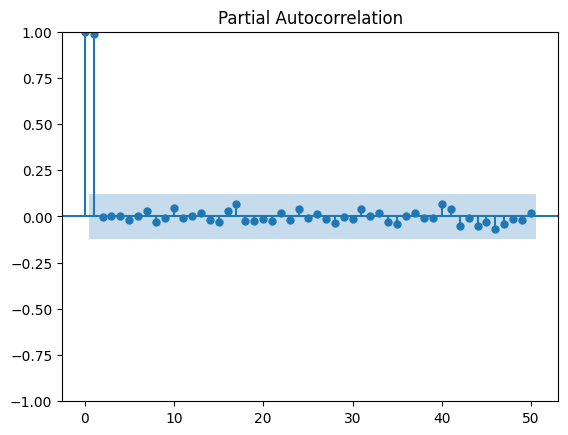

In [29]:
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# create dataset
data = spx['close']
# square the dataset
variance = (spx['close']-spx['close'].mean())**2
# create acf plot
plot_pacf(spx['close'], lags=50)
pyplot.show()

In [32]:
# https://bashtage.github.io/arch/univariate/univariate_volatility_modeling.html
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn

seaborn.set_style("darkgrid")
plt.rc("figure", figsize=(16, 6))
plt.rc("savefig", dpi=90)
plt.rc("font", family="sans-serif")
plt.rc("font", size=14)

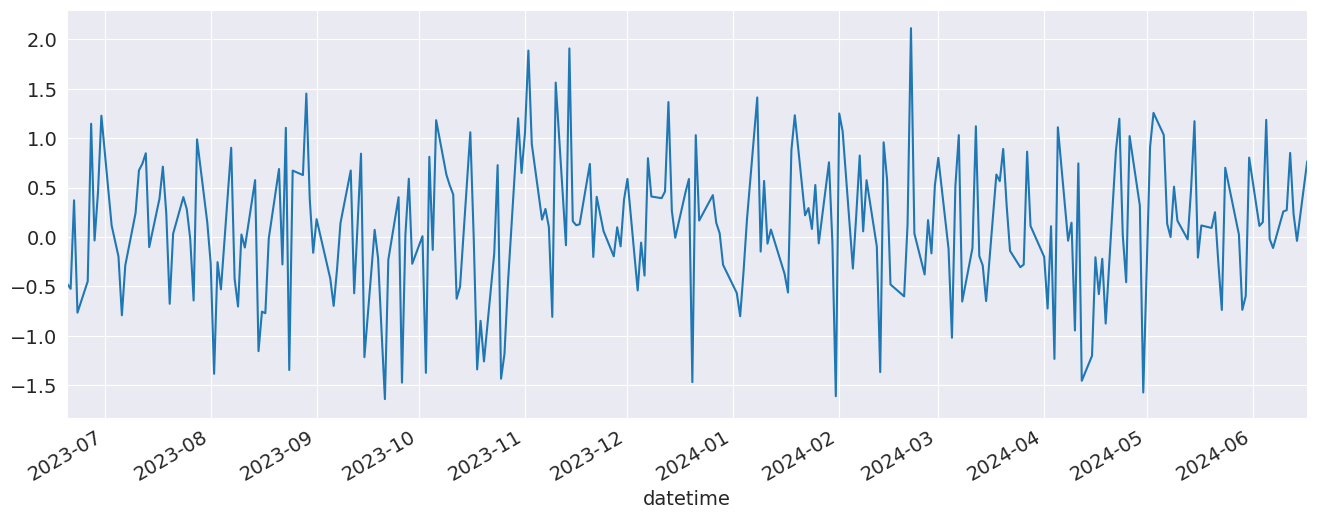

In [33]:
import datetime as dt
data = spx['close']
returns = 100 * spx['close'].pct_change().dropna()
ax = returns.plot()
xlim = ax.set_xlim(returns.index.min(), returns.index.max())

In [34]:
from arch import arch_model

am = arch_model(returns)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     36,   Neg. LLF: 269.9122109649678
Iteration:     10,   Func. Count:     63,   Neg. LLF: 269.8384803653649
Optimization terminated successfully    (Exit mode 0)
            Current function value: 269.8384784132596
            Iterations: 12
            Function evaluations: 72
            Gradient evaluations: 12
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -269.838
Distribution:                  Normal   AIC:                           547.677
Method:            Maximum Likelihood   BIC:                           561.779
                                        No. Observations:                  251
Date:                Mon, Jun 17 2024   Df Residuals:                      250
Time:          

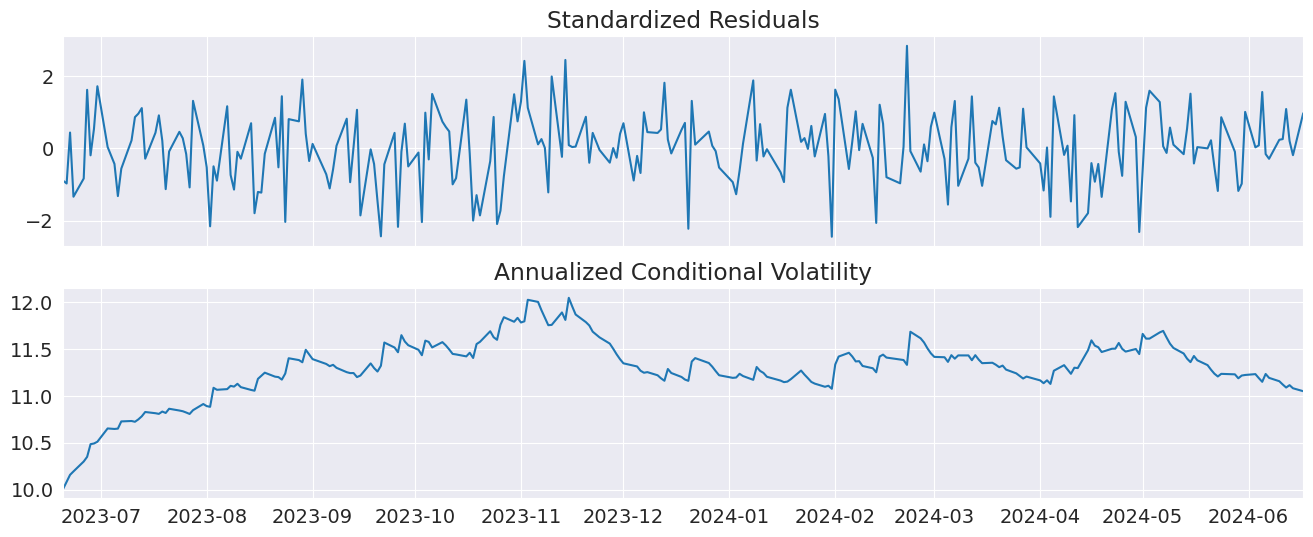

In [35]:
fig = res.plot(annualize="D")

In [48]:
am = arch_model(returns, vol="Garch", p=1, o=0, q=1, dist="Normal")
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     36,   Neg. LLF: 269.9122109649678
Iteration:     10,   Func. Count:     63,   Neg. LLF: 269.8384803653649
Optimization terminated successfully    (Exit mode 0)
            Current function value: 269.8384784132596
            Iterations: 12
            Function evaluations: 72
            Gradient evaluations: 12
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -269.838
Distribution:                  Normal   AIC:                           547.677
Method:            Maximum Likelihood   BIC:                           561.779
                                        No. Observations:                  251
Date:                Mon, Jun 17 2024   Df Residuals:                      250
Time:          

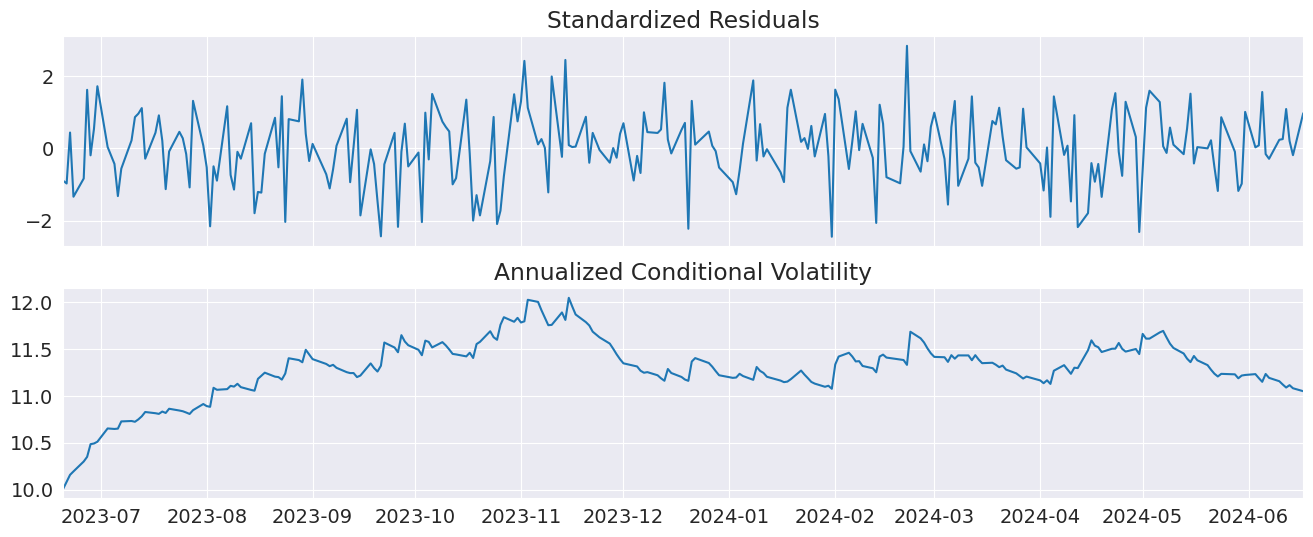

In [49]:
fig = res.plot(annualize="D")

In [37]:
am = arch_model(returns, vol="Garch", p=1, o=0, q=1, dist="Normal")
res = am.fit(update_freq=5)

Iteration:      5,   Func. Count:     36,   Neg. LLF: 269.9122109649678
Iteration:     10,   Func. Count:     63,   Neg. LLF: 269.8384803653649
Optimization terminated successfully    (Exit mode 0)
            Current function value: 269.8384784132596
            Iterations: 12
            Function evaluations: 72
            Gradient evaluations: 12


In [53]:
forecasts = res.forecast(horizon=10)
print(forecasts.mean.iloc[-3:])
print(forecasts.residual_variance.iloc[-3:])
print(forecasts.variance.iloc[-3:])
volatility = np.sqrt(forecasts.variance.iloc[-3:]*252)

                h.01      h.02      h.03      h.04      h.05      h.06  \
datetime                                                                 
2024-06-17  0.090001  0.090001  0.090001  0.090001  0.090001  0.090001   

                h.07      h.08      h.09      h.10  
datetime                                            
2024-06-17  0.090001  0.090001  0.090001  0.090001  
                h.01      h.02      h.03      h.04      h.05      h.06  \
datetime                                                                 
2024-06-17  0.485991  0.487527  0.488976  0.490342  0.491631  0.492846   

                h.07      h.08     h.09     h.10  
datetime                                          
2024-06-17  0.493991  0.495071  0.49609  0.49705  
                h.01      h.02      h.03      h.04      h.05      h.06  \
datetime                                                                 
2024-06-17  0.485991  0.487527  0.488976  0.490342  0.491631  0.492846   

                h.0

In [56]:
volatility.values

array([[11.06659928, 11.08408069, 11.10053953, 11.11603703, 11.13063059,
        11.14437405, 11.15731789, 11.16950952, 11.18099341, 11.19181132]])